In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [3]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Variable	Description

age	Age of the patient in years<BR>
sex	Gender of the patient (0 = male, 1 = female)<BR>
cp	Chest pain type:<BR>

0: Typical angina<BR>
1: Atypical angina<BR>
2: Non-anginal pain<BR>
3: Asymptomatic<BR>
trestbps	Resting blood pressure in mm Hg<BR>
chol	Serum cholesterol in mg/dl<BR>
fbs	Fasting blood sugar level, categorized as above 120 mg/dl (1 = true, 0 = false)<BR>
restecg	Resting electrocardiographic results:<BR>
0: Normal<BR>
1: Having ST-T wave abnormality<BR>
2: Showing probable or definite left ventricular hypertrophy<BR>
thalach	Maximum heart rate achieved during a stress test<BR>
exang	Exercise-induced angina (1 = yes, 0 = no)<BR>
oldpeak	ST depression induced by exercise relative to rest<BR>
slope	Slope of the peak exercise ST segment:<BR>
0: Upsloping<BR>
1: Flat<BR>
2: Downsloping<BR>
ca	Number of major vessels (0-4) colored by fluoroscopy<BR>
thal	Thalium stress test result:<BR>
0: Normal<BR>
1: Fixed defect<BR>
2: Reversible defect<BR>
3: Not described<BR>
target	Heart disease status (0 = no disease, 1 = presence of disease)<BR>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [9]:
df.duplicated().sum()

1

Above analysis shows that there are no null values and most of the features
are having int data type. Also there is one duplicate record which we need to remove it.

In [10]:
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [14]:
df.describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


In [15]:
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


## EDA

For our Exploratory Data Analysis (EDA), we'll take it in two main steps:

1. Univariate Analysis: Here, we'll focus on one feature at a time to understand its distribution and range.

2. Bivariate Analysis: In this step, we'll explore the relationship between each feature and the target variable. This helps us figure out the importance and influence of each feature on the target outcome.

With these two steps, we aim to gain insights into the individual characteristics of the data and also how each feature relates to our main goal: predicting the target variable.

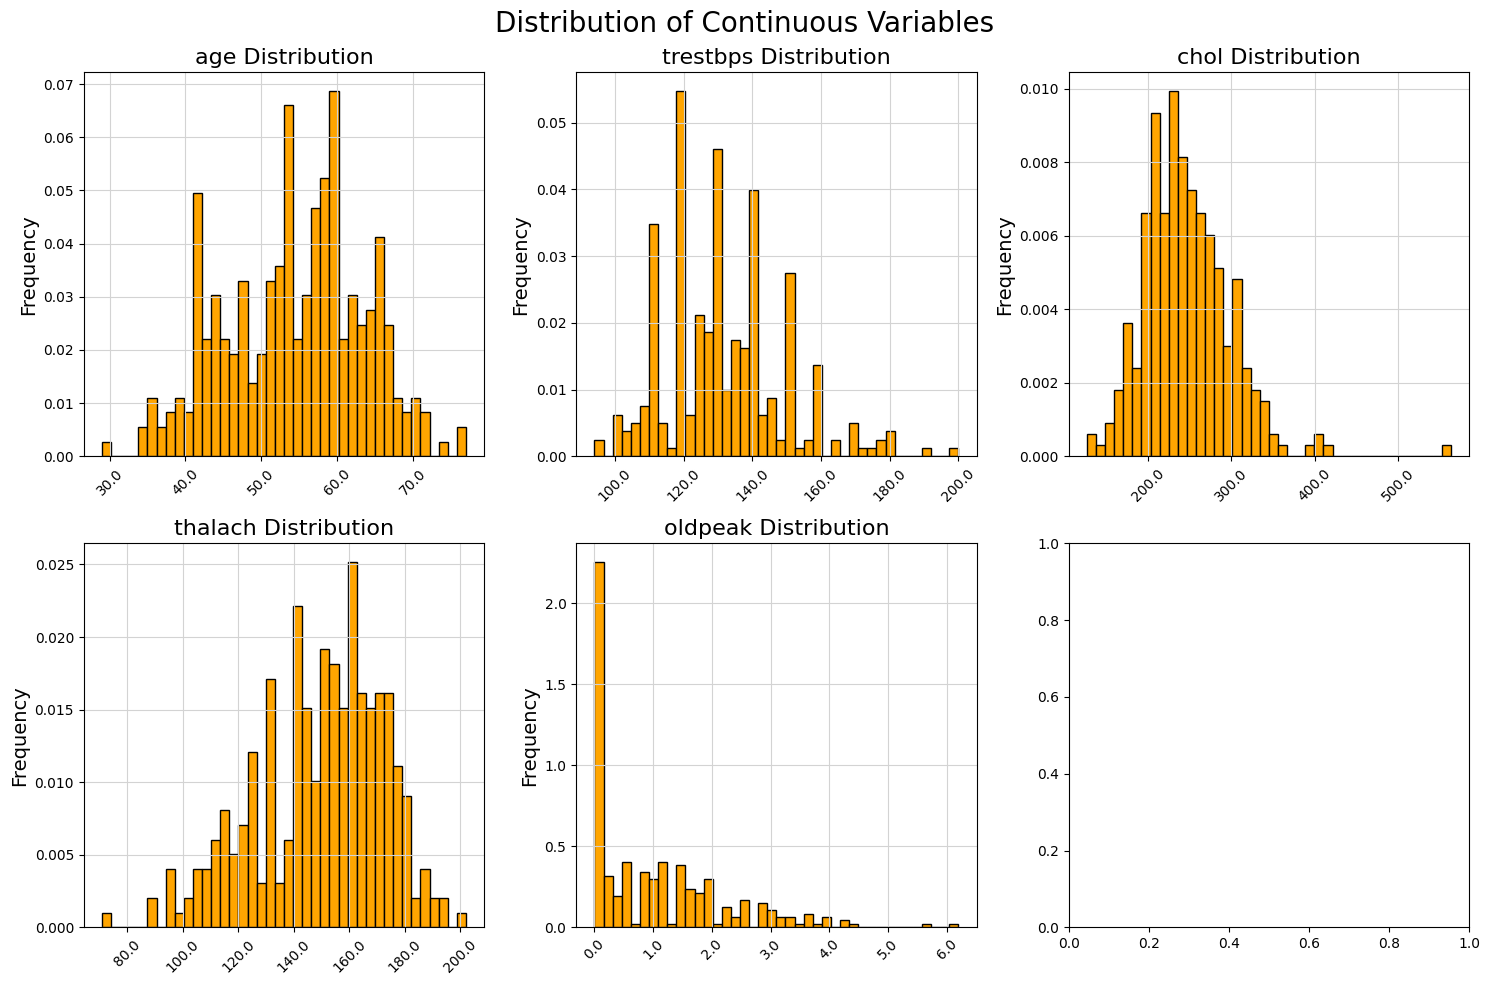

In [117]:
#EDA on Continuos Variables
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cdf = df[continuous_features]

fig, axs = plt.subplots(2, 3, figsize=(15,10))

counter = 0
for i, ax in enumerate(axs.flatten()):
    if counter != len(continuous_features):
        col_name = continuous_features[counter]
        ax.hist(df[col_name], color='orange', edgecolor='black', density=True,bins=40)
        ax.set_title(f'{col_name} Distribution', fontsize=16)
        
        ax.set_ylabel('Frequency', fontsize=14)
        #ax.set_xticks(np.round(bin_edges, 1))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.grid(color='lightgrey')
        counter += 1
    
    
# axs[0,0].hist(cdf['age'])
# axs[0,1].hist(cdf['trestbps'])
# axs[0,2].hist(cdf['trestbps'])
# axs[1,0].hist(cdf['trestbps'])
# axs[1,1].hist(cdf['trestbps'])
# axs[1,2].hist(cdf['oldpeak'])


plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.show()

In [153]:
for i,col in enumerate(catg_features):
    print(i,col)

0 sex
1 cp
2 fbs
3 restecg
4 exang
5 slope
6 ca
7 thal
8 target


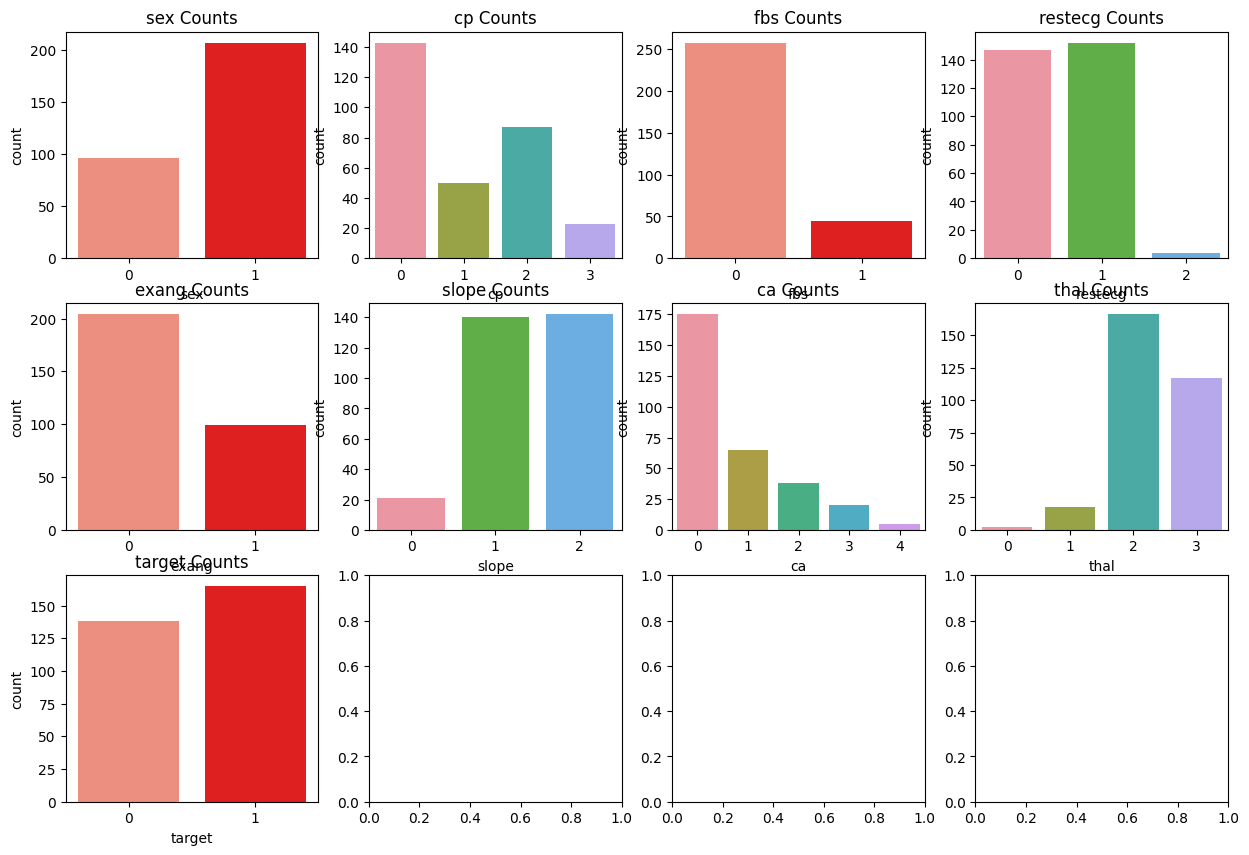

In [171]:
#EDA on Continuos Variables
df2=df.select_dtypes(include='object')
catg_features = df2.columns.tolist()

fig, axs = plt.subplots(3,4, figsize=(15,10))
row = 0
column = 0
for i,col in enumerate(catg_features):
    if i == 4 or i == 8:
        row += 1
        column = 0
    sns.countplot(data=df,x=df[col],ax=axs[row,column]).set_title(f'{col} Counts')
    column += 1
plt.show()

## Numerical Features vs Target

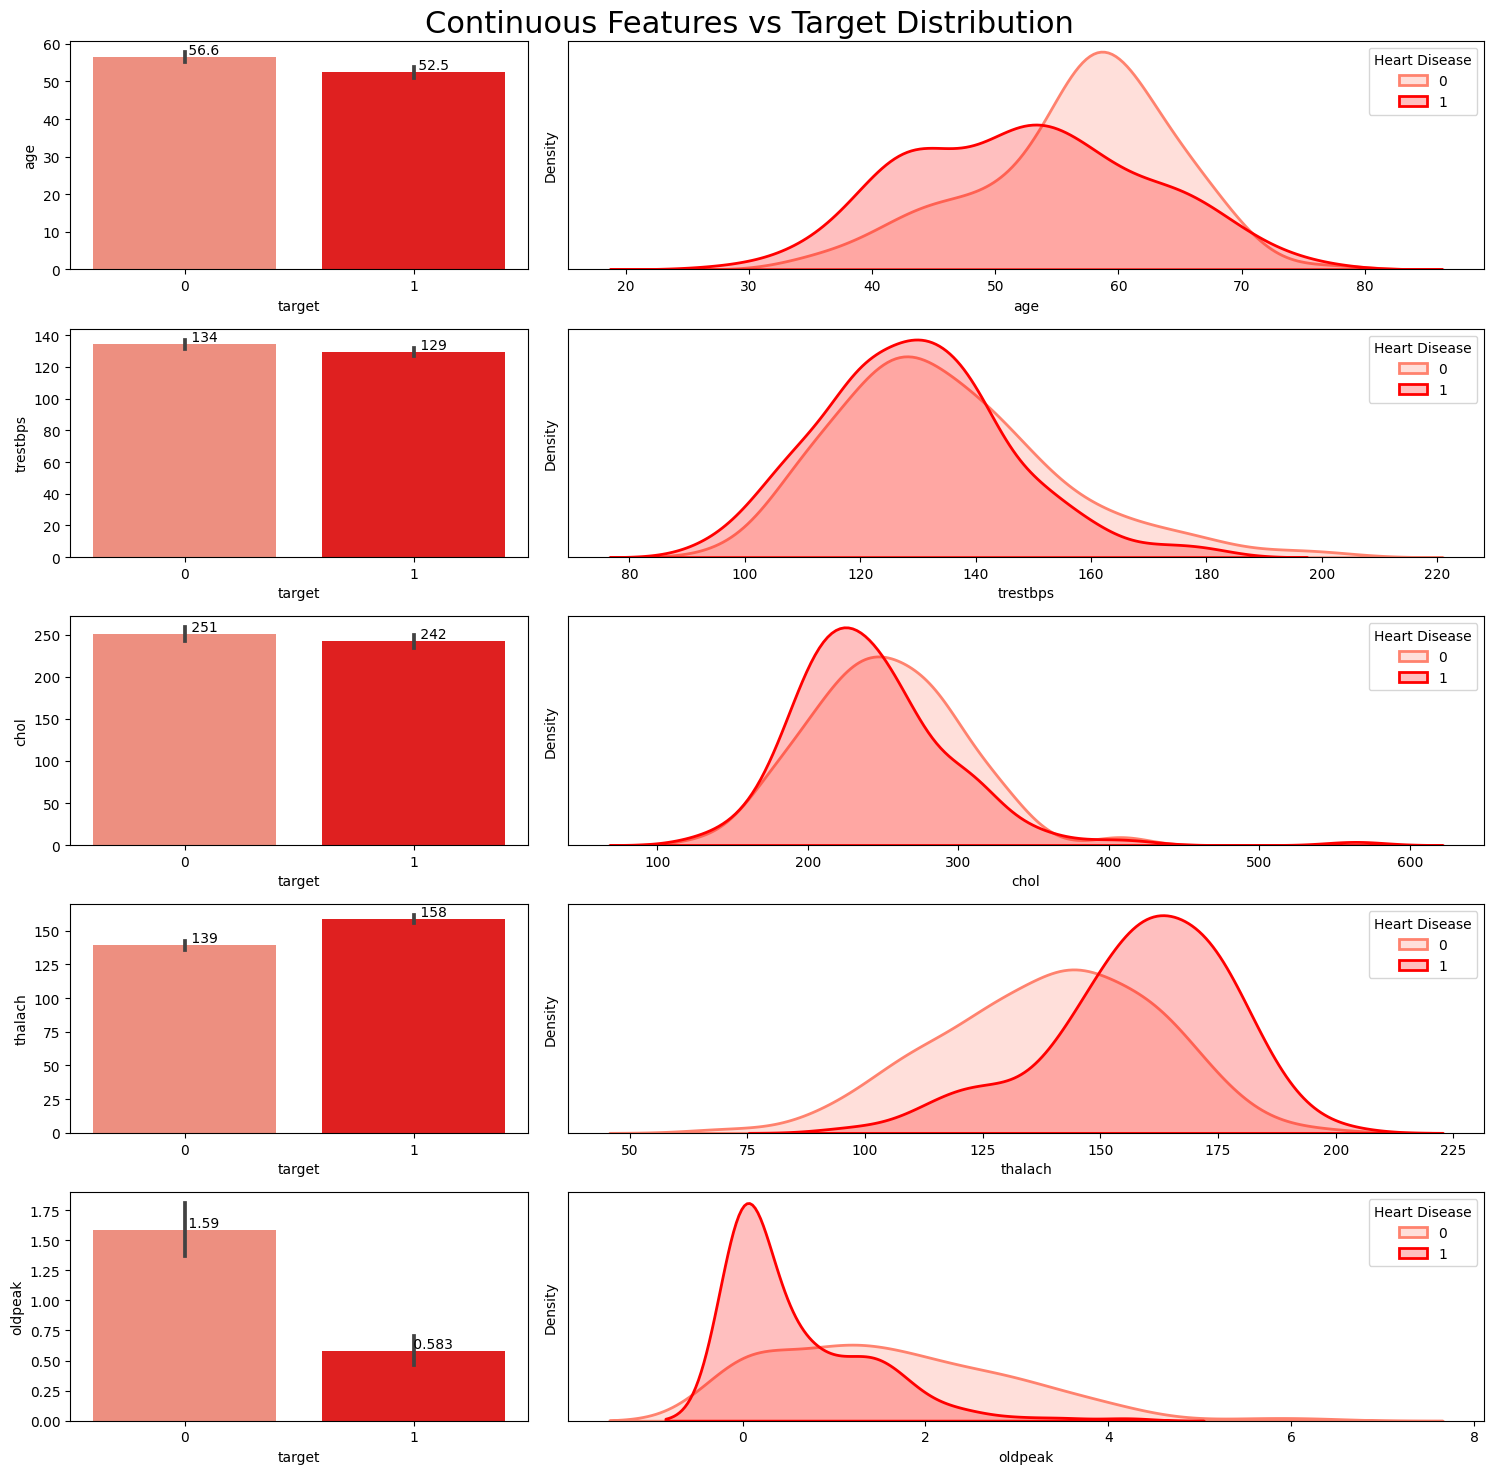

In [140]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

In [141]:
import pandas_profiling as pp
#df = pd.read_excel("WBNAME", sheetname = None)
profile= pp.ProfileReport(df)
profile.to_file('pandas_profile_test.html')

Based on Pandas Profiling, below is the Analyzing Points:

1. There are no missing values in the dataset.
2. There is only one duplicate records which we need to remove from the dataset.
3. Age Feature - Age ranges between 29 to 77 where Range is 48. There is left skewness -0.2 in age feature. Mean value of age is 54.366

4. CP, thal values are highly correlated with Target Feature
5. OldPeak feature has 32.7% entry where values are equal to zero.

##  Outliers Treatment

In [145]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

Above analysis shows that there are few outliers in all the continuos features except age! Since we have smaller amount of dataset we can not simply remove the outliers and change the variation in the dataset. Instead of we will use Power or Function Transformers to remove the outliers in the dataset.

Sensitivity to Outliers:

<b>SVM (Support Vector Machine)</b>: SVMs can be sensitive to outliers. While the decision boundary is determined primarily by the support vectors, outliers can influence which data points are chosen as support vectors, potentially leading to suboptimal classification.

<b>Decision Trees (DT) and Random Forests (RF)</b>: These tree-based algorithms are generally robust to outliers. They make splits based on feature values, and outliers often end up in leaf nodes, having minimal impact on the overall decision-making process.

<b>K-Nearest Neighbors (KNN)</b>: KNN is sensitive to outliers because it relies on distances between data points to make predictions. Outliers can distort these distances.

<b>AdaBoost</b>: This ensemble method, which often uses decision trees as weak learners, is generally robust to outliers. However, the iterative nature of AdaBoost can sometimes lead to overemphasis on outliers, making the final model more sensitive to them.


##  Data Preprocessing

In [149]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Convert the rest of the categorical variables that don't need one-hot encoding to integer data type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,1,0,1,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,1,1,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,1,1,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,1,0,0,0,1,0,0,1,0


In [205]:
df_encoded.to_csv('cleaned.csv')

Box-Cox transformation is a powerful method to stabilize variance and make the data more normal-distribution-like. It's particularly useful when you're unsure about the exact nature of the distribution you're dealing with, as it can adapt itself to the best power transformation. However, the Box-Cox transformation only works for positive data, so one must be cautious when applying it to features that contain zeros or negative values.

To do transformation first we will split the dataset into training & testing so that there would be no data leakage problem. Then we will apply transformation technique. Then we will check whether we have achieved the normal distribution or not!

In [201]:
from sklearn.model_selection import train_test_split
X = df_encoded.drop('target',axis=1)
y = df_encoded['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0, stratify=y)

In [202]:
# Applying Box-Cox Transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox')

X_train_transformed = pt.fit_transform(X_train+0.000001)
X_test_transformed = pt.transform(X_test+0.000001)

#pd.DataFrame({'cols':X_train.columns,'box_cox_lambdas':pt.lambdas_})

####  Let's see the distribution now after transformation!

In [203]:
columns = X_train.columns.tolist()
X_Transformed = pd.DataFrame(data = X_train_transformed,columns=columns)

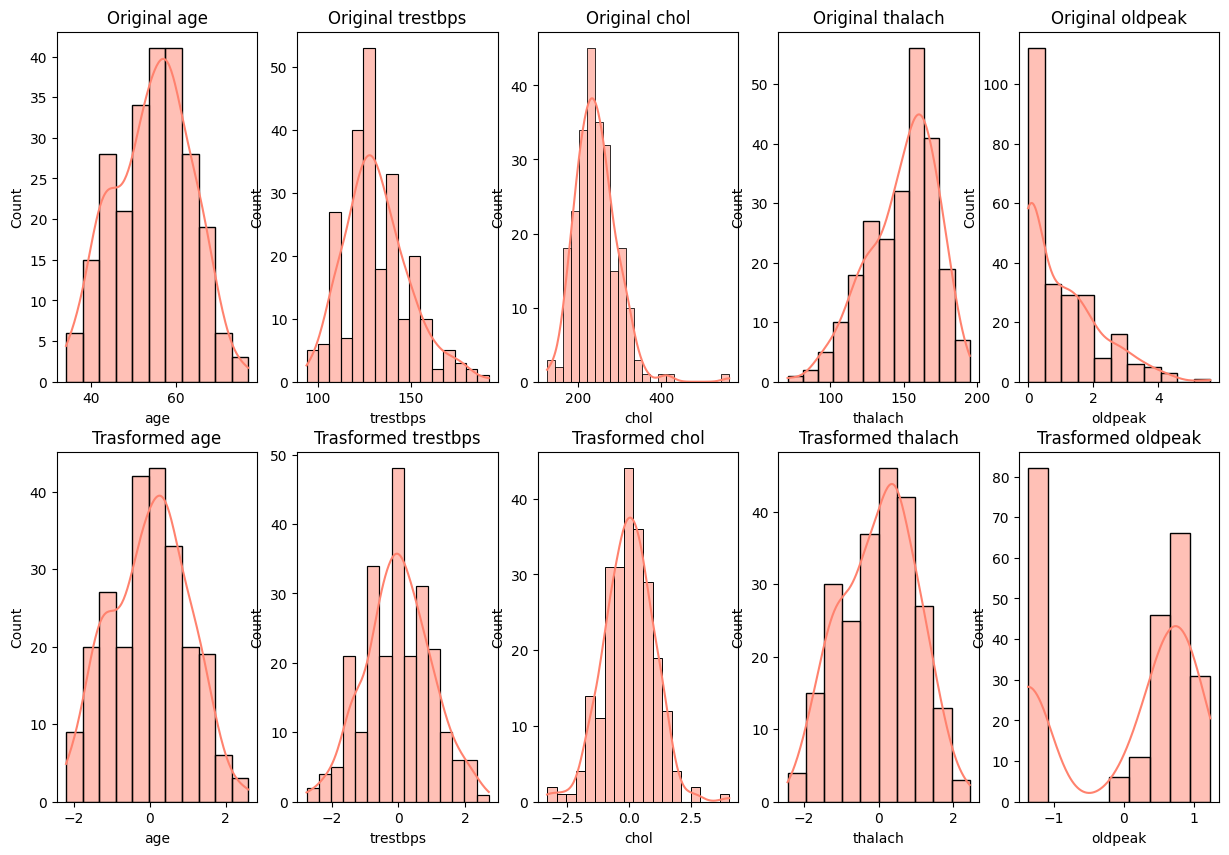

In [204]:
# Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 5, figsize=(15,10))

# Original Distributions
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'Original {col}')
    
# Transformed Distributions
for i, col in enumerate(continuous_features):
    sns.histplot(X_Transformed[col], kde=True, ax=ax[1,i], color='#ff826e').set_title(f'Trasformed {col}')   
    

Above analysis shows that we have successfully transformed the distribution to normal distribution.

Transforming features to be more normal-like primarily helps in mitigating the impact of outliers, which is particularly beneficial for distance-based algorithms like SVM and KNN. By reducing the influence of outliers, we ensure that these algorithms can compute distances more effectively and produce more reliable results.

## Model Building

In [234]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [235]:
from sklearn.model_selection import GridSearchCV
models_name = {
    'LR':LogisticRegression(),
    'RFC':RandomForestClassifier(),
    'DTC':DecisionTreeClassifier(),
    'SVC': SVC(), 
    'GBC':GradientBoostingClassifier()
}


params_dict = {
    'LR':{'penalty':['l2'],
         'dual':[False],
         'fit_intercept':[True,False]},
    'RFC':{'n_estimators':[10,20,30,50,80],
          'criterion':['gini', 'entropy'],'max_depth':[2,5,6,8],'min_samples_split':[2,5,6,8],
          'min_samples_leaf':[2,5,6,8],'max_features':[1,2,3,4],'bootstrap':[True,False]},
    'DTC':{'splitter':['best','random'],
        'criterion':['gini', 'entropy'],
          'max_depth':[2,5,6,8],
          'min_samples_split':[2,5,6,8],
          'min_samples_leaf':[2,5,6,8],
          'max_features':[1,2,3,4],
          'max_leaf_nodes':[2,5,6,8]},
    'SVC':{'C':[1.0,1.2,1.4,1.5],'kernel':['rbf','linear','poly','sigmoid'],'degree':[1,2,3],
            'gamma':['scale','auto'],'shrinking':[True,False],'shrinking':[True,False]},
    'GBC':{'loss':['exponential'],'learning_rate':[0.1,0.2],'n_estimators':[100,150,200],
            'max_depth':[2,5,6,8],'min_samples_split':[2,5,6,8],'min_samples_leaf':[2,5,6,8]}
}



In [275]:
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.model_selection import RandomizedSearchCV

#X_train_transformed
#X_test_transformed


Precision_Score = []
Recall_Score = []
F1_Score = []
Model_List = []
Accuracy_Score = []
Best_Parameters = []
for key,value in models_name.items():
    Model_Parameters = params_dict[key]
    grid = RandomizedSearchCV(value , param_distributions=Model_Parameters, cv=5, return_train_score=False,error_score='raise',n_jobs=-1)
    grid.fit(X_train_transformed,y_train.values)
    Model_List.append(key)
    Accuracy_Score.append(grid.best_score_)
    Best_Parameters.append(grid.best_params_)
    Precision_Score.append(precision_score(y_test,grid.predict(X_test_transformed)))
    Recall_Score.append(recall_score(y_test,grid.predict(X_test_transformed)))
    F1_Score.append(f1_score(y_test,grid.predict(X_test_transformed)))
    print(key, 'model has been completed!')


#Main_list = [Model_List,Accuracy_Score,Best_Parameters]
Result_df = pd.DataFrame({'Model Name':Model_List,'Accuracy':Accuracy_Score,
                          'Best Parameters':Best_Parameters,'Precision_Score':Precision_Score,
                        'Recall_Score':Recall_Score,'F1_Score':F1_Score})
print('Done')

LR model has been completed!
RFC model has been completed!
DTC model has been completed!
SVC model has been completed!
GBC model has been completed!
Done


In [282]:
Result_df.sort_values('Accuracy',ascending=False,inplace=True)
Result_df.reset_index(inplace=True)

Above analysis shows that RFC, GBC are the best two algorithms to use in the modle building. Howver our dataset is slightly imbalanced so we will surely go ahead with Recall Score. Select that model where we are getting High Recall score as our main goal is to reduce Type 2 Error i.e., to reduce False Negative.

In [296]:
#Lets train our model based on RFC
rfc = RandomForestClassifier(n_estimators=50,min_samples_split= 8,
                             min_samples_leaf= 5,
                             max_features= 4,
                             max_depth= 5,
                             criterion= 'gini',
                             bootstrap= False)

rfc.fit(X_train_transformed,y_train.values)
print(precision_score(y_test,rfc.predict(X_test_transformed)))
print(recall_score(y_test,rfc.predict(X_test_transformed)))

0.8285714285714286
0.8787878787878788


In [299]:
from sklearn.metrics import confusion_matrix
print("RFC Confusion Matrix\n")
y_pred = rfc.predict(X_test_transformed)
confusion_matrix(y_test,y_pred)

RFC Confusion Matrix



array([[22,  6],
       [ 4, 29]], dtype=int64)

In [300]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

